# Use Spacy

* For preprocessing : we will use spacy's lemmatization to enhance -hopefully- our 'nb common words' feature
* At the same time, find entities, locations, any object of interest detected by spacy
    * use these infos to do some usable visualisation of training deactivated
    * qualify questions with nb of entities

Ex : Will Donald Trump be elected -> Will <person> be elected + 1 person

### Notes        
* nlp model : en_core_web_md  (medium)
* nlp pipeline is partially deactivated: tagger,parser,textcat are unused
* even when 7 cores are used, awfully slow. 


In [1]:
# Ugly incantation to make our framework working
import sys
sys.path.insert(0, r'/SAPDevelop/QuoraPairs/BruteForce/Tools')

#import all our small tools (paths, cache, print,zip,excel, pandas, progress,..)
from Tools.all import *

# setup the name of our experiment
# it will be used to store every result in a unique place
EXPERIMENT='spacy_preprocessing'
print_alert('You will work on experiment %s' %EXPERIMENT)
UNITARY_TEST=1

In [2]:
prepare_environnement(EXPERIMENT)
train_dataframe=load_dataframe(CLEAN_TRAINING_DATA)
challenge_dataframe=load_dataframe(CLEAN_CHALLENGE_DATA)
print_section('Untouched input data has been loaded. Training: %d lines Challenge: %d lines' % (len(train_dataframe),len(challenge_dataframe)))

def build_all_lower_data(dataframe):
    print_info('Lower case question1')
    dataframe['question1'] = dataframe['question1'].str.lower()
    print_info('Lower case question2')
    dataframe['question2'] = dataframe['question2'].str.lower()
    return dataframe

# our main tool to add feature
def add_column_from_columns(dataframe,output_column_name,function):
    dataframe[output_column_name]=dataframe.progress_apply(function,axis=1)
    return dataframe[output_column_name]

def add_column_from_column(dataframe,output_column_name,input_column_name,function):
    dataframe[output_column_name]=dataframe[input_column_name].progress_apply(function)
    return dataframe[output_column_name]

train_dataframe = load_or_build_dataframe('Lower case everything in training','training_lower',build_all_lower_data,train_dataframe)
challenge_dataframe = load_or_build_dataframe('Lower case everything in challenge','challenge_lower',build_all_lower_data,challenge_dataframe)


## First step : clean data

We will use our best clean_string preprocessing coming from notebook **find_preprocessing** slightly modified:
* removing stop words is not done hoping it will help spacy in its detection of entities


In [3]:
import re

# I do special stuff with $ and roupie char
FINAL_PUNC_CLEANER = str.maketrans(dict([ (c,' ') for c in '!"#%&\'()*+,./:;<=>?[\\]^_`{|}~-@']))

def clean_string(str):
    str = re.sub('\?',' ',str) # ?
    # odd chars
    # will generate more ' so do it first
    str = re.sub("’", "'", str) # special single quote
    str = re.sub("`", "'", str) # special single quote
    str = re.sub("“", '"', str) # special double quote
    str = re.sub("？", "?", str) 
    str = re.sub("…", " ", str) 
    str = re.sub("é", "e", str)
    
    # shortcuts
    str = re.sub('\'s', ' is', str) 
    str = re.sub(' whats ', ' what is ', str)
    str = re.sub('\'ve', ' have ', str)
    str = re.sub("can't", 'can not', str)
    # this one is tricky do it in order
    str = re.sub("wouldn't", 'would not', str)
    str = re.sub("n't", ' not ', str)
    str = re.sub("i'm", 'i am', str)
    str = re.sub('\'re', ' are ', str)
    str = re.sub('\'d', ' would ', str)
    str = re.sub('\'ll', ' will ', str)
    str = re.sub('e\.g\.', ' eg ', str)
    str = re.sub('b\.g\.', ' bg ', str)
    str = re.sub('e-mail', ' email ', str)
    str = re.sub('\(s\)', ' ', str)

    # Numbers and measures are a true mess
    # 12,000 -> 12000
    str = re.sub('(?<=[0-9])\,(?=[0-9])', '', str)

    # Quora is very used in India so roupie (rs) is often present
    str = re.sub("(?<=[0-9])rs ", " rs ", str)
    str = re.sub(" rs(?=[0-9])", " rs ", str)

    # stolen at kaggle : https://www.kaggle.com/currie32/the-importance-of-cleaning-str

#    str = re.sub('[c-fC-F]\:\/', ' disk ', str)
#    str = re.sub('(\d+)(kK)', ' \g<1>000 ', str)
    # very weird !!! these ones decrease the hit % WTF ?

    #str = re.sub(r" (the[\s]+|the[\s]+)?us(a)? ", " usa ", str)
    #str = re.sub('(the[\s]+|the[\s]+)?united state(s)?', ' usa ', str)

    str = re.sub(r" uk ", " england ", str)
    str = re.sub(r" imrovement ", " improvement ", str)
    str = re.sub(r" intially ", " initially ", str)
    str = re.sub(r" dms ", " direct messages ", str)  
    str = re.sub(r" demonitization ", " demonetization ", str) 
    str = re.sub(r" actived ", " active ", str)
    str = re.sub(r" kms ", " kilometers ", str)
    str = re.sub(r" cs ", " computer science ", str) 
    str = re.sub(r" upvote", " up vote", str)
    str = re.sub(r" iphone ", " phone ", str)
    str = re.sub(r" \0rs ", " rs ", str)
    str = re.sub(r" calender ", " calendar ", str)
    str = re.sub(r" ios ", " operating system ", str)
    str = re.sub(r" programing ", " programming ", str)
    str = re.sub(r" bestfriend ", " best friend ", str)
    str = re.sub(r" iii ", " 3 ", str)
    str = re.sub(r" banglore ", " bangalore ", str)
    str = re.sub(r" j k ", " jk ", str)
    str = re.sub(r" J\.K\. ", " jk ", str)

    
    # some others
    str = re.sub(r"60k", " 60000 ", str)
    str = re.sub(r" e g ", " eg ", str)
    str = re.sub(r" b g ", " bg ", str)
    str = re.sub(r"\0s", "0", str)
    str = re.sub(r" 9 11 ", "911", str)
    str = re.sub(r"\s{2,}", " ", str)
    str = re.sub(r" usa ", " America ", str)
    str = re.sub(r" u s ", " America ", str)
    str = re.sub(r"'m ", " am ", str)

    # units
    str = re.sub(r"(\d+)kgs ", lambda m: m.group(1) + ' kg ', str)        # e.g. 4kgs => 4 kg
    str = re.sub(r"(\d+)kg ", lambda m: m.group(1) + ' kg ', str)         # e.g. 4kg => 4 kg
    str = re.sub(r"(\d+)k ", lambda m: m.group(1) + '000 ', str)          # e.g. 4k => 4000
    str = re.sub(r"\$(\d+)", lambda m: m.group(1) + ' dollar ', str)
    str = re.sub(r"(\d+)\$", lambda m: m.group(1) + ' dollar ', str)
    # This one is important in 2017
    str = re.sub(' donald trump',' trump ',str)
    str = re.sub(' dollars',' dollar ',str)
    str = re.sub(' quaro',' quora ',str)
    str = re.sub(r"googling", " google ", str)
    str = re.sub(r"googled", " google ", str)
    str = re.sub(r"googleable", " google ", str)
    str = re.sub(r"googles", " google ", str)
    
    str = re.sub(r"₹", " rs ", str)      # 测试！
    str = re.sub(r"\$", " dollar ", str)  
    
    # this will blank any of !"#%&\'()*+,./:;<=>?[\\]^_`{|}~-@
    # Note the @ is dubious : won't we loose some emails ??
    # and $ is replaced by dollar before
    str = str.translate(FINAL_PUNC_CLEANER)
    return str
    
def clean(dataframe):
    print_warning('Just remove noise from questions (no stop words)')
    add_column_from_column(dataframe,'question1','question1',clean_string)
    add_column_from_column(dataframe,'question2','question2',clean_string)
    return dataframe

train_dataframe = load_or_build_dataframe('Training data + clean (no stop words)','training_clean_no_stop_words',clean,train_dataframe)
challenge_dataframe = load_or_build_dataframe('Challenge data + clean + (no stop words)','challenge_clean_no_stop_words',clean,challenge_dataframe)


## Start with spacy

### Step 1: Lemmatize the questions

Note: 
We deactivate part of the standard Spacy pipeline : tagger,parser,textcat. They are useless here and still awfully slow

In [4]:
# Spacy stuff
import spacy
spacy_nlp = spacy.load('en_core_web_sm',disable=['tagger','parser','textcat'])

def lemmatize(dataframe,question_name):
    start = time.time()
    lemmes = list()
    print_info('Lemmatisation of %s' % question_name)
    for d in tqdm(spacy_nlp.pipe(dataframe[question_name],batch_size=1000,n_process=os.cpu_count()-1),total=len(dataframe)):
         lemmes.append(' '.join([word.lemma_ for word in d]))
    print_done('Lemmatisation of %s done' % question_name,top=start)
    return lemmes

def lemmatize_all(dataframe):
     # We don't keep old question1, question2
     dataframe['question1'] = lemmatize(dataframe,'question1')
     dataframe['question2'] = lemmatize(dataframe,'question2')
     return dataframe

In [5]:
train_dataframe = load_or_build_dataframe('Training data: lemmatize','training_lemmatized',lemmatize_all,train_dataframe)
challenge_dataframe = load_or_build_dataframe('Challenge data: lemmatize','challenge_lemmatized',lemmatize_all,challenge_dataframe)

### Step 2 find entities

Figure what is available in spacy

In [6]:
# These are all the entities detected by Spacy

ALL_ENTITIES_TYPES = [
            'GPE',
            'PERSON',
            'PRODUCT',
            'CARDINAL',
            'ORG',
            'ORDINAL',
            'TIME',
            'DATE',
            'NORP',
            'WORK_OF_ART',
            'LANGUAGE',
            'EVENT',
            'FAC',
            'MONEY',
            'LAW',
            'LOC',
            'QUANTITY',
            'PERCENT'
            ]
# What is there inside ?
print_info("Description of spacy's entities")
[ ':'.join([t,spacy.explain(t)]) for t in ALL_ENTITIES_TYPES]


['GPE:Countries, cities, states',
 'PERSON:People, including fictional',
 'PRODUCT:Objects, vehicles, foods, etc. (not services)',
 'CARDINAL:Numerals that do not fall under another type',
 'ORG:Companies, agencies, institutions, etc.',
 'ORDINAL:"first", "second", etc.',
 'TIME:Times smaller than a day',
 'DATE:Absolute or relative dates or periods',
 'NORP:Nationalities or religious or political groups',
 'WORK_OF_ART:Titles of books, songs, etc.',
 'LANGUAGE:Any named language',
 'EVENT:Named hurricanes, battles, wars, sports events, etc.',
 'FAC:Buildings, airports, highways, bridges, etc.',
 'MONEY:Monetary values, including unit',
 'LAW:Named documents made into laws.',
 'LOC:Non-GPE locations, mountain ranges, bodies of water',
 'QUANTITY:Measurements, as of weight or distance',
 'PERCENT:Percentage, including "%"']

In [7]:
import copy

ALL_ENTITIES_TYPES_COUNT = {
            'GPE':0,
            'PERSON':0,
            'PRODUCT':0,
            'CARDINAL':0,
            'ORG':0,
            'ORDINAL':0,
            'TIME':0,
            'DATE':0,
            'NORP':0,
            'WORK_OF_ART':0,
            'LANGUAGE':0,
            'EVENT':0,
            'FAC':0,
            'MONEY':0,
            'LAW':0,
            'LOC':0,
            'QUANTITY':0,
            'PERCENT':0
            }            

def sniff_entities(dataframe,question_name):
    start = time.time()
    entities = list()
    print_info('Find entities of %s' % question_name)
    for d in tqdm(spacy_nlp.pipe(dataframe[question_name],batch_size=1000,n_process=os.cpu_count()-1),total=len(dataframe)):
        res = copy.deepcopy(ALL_ENTITIES_TYPES_COUNT)
        for i in d.ents:
            # to count all entities
            #res[i.label_]+=1
            # to count only if there is one
            res[i.label_]=1
            
        entities.append(res)
    print_done('Done',top=start)
    return entities

#res = pandas.DataFrame.from_dict(sniff_entities(train_dataframe.sample(20000,random_state=42),'question1'))
res = pandas.DataFrame.from_dict(sniff_entities(train_dataframe.sample(20000,random_state=42),'question1'))


In [8]:
#for c in res.columns:
#    print(c,res[c].sum())
abstract=pandas.DataFrame([(c,res[c].sum()/len(res)) for c in res.columns])
abstract.sort_values(1)

,0,1
17,PERCENT,0.00015
9,WORK_OF_ART,0.00040
14,LAW,0.00050
12,FAC,0.00255
5,ORDINAL,0.00285
13,MONEY,0.00320
11,EVENT,0.00360
2,PRODUCT,0.00470
6,TIME,0.00505
16,QUANTITY,0.00635


We will focus on a subset
* GPE : Countries, cities, states',
* PERSON : People, including fictional',
* PRODUCT : Objects, vehicles, foods, etc. (not services)',
* ORG : Companies, agencies, institutions, etc.',
* DATE : Absolute or relative dates or periods',
* NORP : Nationalities or religious or political groups',
* WORK_OF_ART : Titles of books, songs, etc.',
* LANGUAGE : Any named language',
* EVENT : Named hurricanes, battles, wars, sports events, etc.',
* FAC : Buildings, airports, highways, bridges, etc.',
* LAW : Named documents made into laws.',
* LOC : Non-GPE locations, mountain ranges, bodies of water',


In [9]:
import copy
 
ENTITIES_TO_KEEP =  {
    'GPE' : [], # Countries, cities, states',
    'PERSON' : [], #People, including fictional',
    'PRODUCT' : [], #Objects, vehicles, foods, etc. (not services)',
    'ORG' : [], # Companies, agencies, institutions, etc.',
    'DATE' : [], # Absolute or relative dates or periods',
    'NORP' : [],  # Nationalities or religious or political groups',
    'WORK_OF_ART' : [], #Titles of books, songs, etc.',
    'LANGUAGE' : [], # Any named language',
    'EVENT' : [], # Named hurricanes, battles, wars, sports events, etc.',
    'FAC' : [], # Buildings, airports, highways, bridges, etc.',
    'LAW' : [], # Named documents made into laws.',
    'LOC' : [] # Non-GPE locations, mountain ranges, bodies of water',
 }

# we build carefully a big template from ENTITIES_TO_KEEP
# it contains for each type we ant to track
# the list of entities
# the # of entities
# Not yet the # of entities common to question1 and question2. it will be count later
ENTITIES_NB = dict( [('nb_'+k,0) for k in ENTITIES_TO_KEEP.keys()])
ENTITIES_COMMON = dict( [('nb_common_'+k,0) for k in ENTITIES_TO_KEEP.keys()])

ENTITIES_RES=copy.deepcopy(ENTITIES_TO_KEEP)
ENTITIES_RES.update(ENTITIES_NB)

# not used but to keep
def track_entities(s):
    d = copy.deepcopy(ENTITIES_TO_KEEP)
    [d[i.label_].append(str(i)) for i in spacy_nlp(s).ents if i.label_ in ENTITIES_TO_KEEP]
    return d
track_entities('clare Finn is living in Paris near Argenteuil where NATO is. clare Finn is working at NATO')

# quite tricky code to adapt automatically to ENTITIES_TO_KEEP

# generate a new dict like ENTITIES_TO_KEEP 
# storing list of entities of each type

def entitize(dataframe,question_name):
    start = time.time()
    entities = list()
    print_info('Find entities of %s' % question_name)
    for d in tqdm(spacy_nlp.pipe(dataframe[question_name],batch_size=1000,n_process=os.cpu_count()-1),total=len(dataframe)):
        res = copy.deepcopy(ENTITIES_RES)
        [res[i.label_].append(str(i)) for i in d.ents if i.label_ in ENTITIES_TO_KEEP]
        [res.update({'nb_'+k:len(res[k])}) for k in ENTITIES_TO_KEEP.keys()]
        entities.append(res)
    print_done('Done',top=start)
    return entities

def find_common_entities(q1,q2):
    start = time.time()
    print_info('Finding common entities')
    final = list()
    for r1,r2 in tqdm(zip(q1,q2),total=len(q1)):
        res = dict()
        for k in ENTITIES_TO_KEEP.keys():
            e_r1 = r1[k]
            e_r2 = r2[k]
            if len(e_r1)>0 and len(e_r2)>0:
                c = len(set(r1[k]) & set(r2[k]))
                res['nb_common_'+k] = len(set(r1[k]) & set(r2[k]))
            else:
                res['nb_common_'+k] = 0
        final.append(res)
    print_done('Done',top=start)
    return final

def entitize_all(dataframe):
     # Produce a dataframe with columns GPE, PERSON, ...,nb_GPE,nb_PERSON,...
     res_q1 = entitize(dataframe,'question1')
     res_q2 = entitize(dataframe,'question2')
     # we have all counts, now compare and find the nb of common entities for each type
     res_common = find_common_entities(res_q1,res_q2)

     # transform dict to dataframe
     res_q1 = pandas.DataFrame.from_dict(res_q1)    
     # rename columns to GPE_question1,PERSON_question1,...,nb_GPE_question1,nb_PERSON_question1,...
     res_q1.columns = [k+'_'+'question1' for k in res_q1.columns]

     res_q2 = pandas.DataFrame.from_dict(res_q2)    
     res_q2.columns = [k+'_'+'question2' for k in res_q2.columns]
     
     res_common = pandas.DataFrame.from_dict(res_common)    

     # glue the new dataframe to input one. 
     # set_index does all the trick. Otherwise, you get some crashes
     dataframe = pandas.concat([dataframe,res_q1.set_index(dataframe.index)],axis=1)
     dataframe = pandas.concat([dataframe,res_q2.set_index(dataframe.index)],axis=1)
     dataframe = pandas.concat([dataframe,res_common.set_index(dataframe.index)],axis=1)

     # Now we add the ratio comon/total for each type
     print_info('Computing all ratios')
     all_nb_tot_columns = [c for c in dataframe.columns if 'nb' in c and 'common' not in c]
     all_nb_common_columns = [c for c in dataframe.columns if 'nb_common' in c]
     for nb_tot,nb_common in tqdm(zip(all_nb_tot_columns,all_nb_common_columns)):
         ratio_name = 'ratio_'+nb_common
         # a column full of 0s
         dataframe[ratio_name] = 0
         # for all those we can we compute the 1/nb, we will update it
         mask = (dataframe[nb_tot]>0)
         dataframe[ratio_name][mask] = dataframe[nb_common]/dataframe[nb_tot]
     return dataframe



In [10]:
#small_to_keep = train_dataframe.sample(1000,random_state=42).copy()
#small_res = entitize_all(small_to_keep)
#small_res.describe()
#small_res[small_res['ratio_nb_common_GPE']].head(2).transpose()
# small_res.describe().transpose()
#mask = (small_res['nb_GPE_question1']>0)
#small_res['ratio'] = 0
#small_res['ratio'][mask]=small_res['nb_common_GPE']/small_res['nb_GPE_question1']
#small_res[small_res['ratio']>0]
#small_res['ratio'] = small_res.mask([small_res['nb_GPE_question1']>0 and small_res['nb_GPE_question2']>0],1,0)



In [11]:
train_dataframe = load_or_build_dataframe('Training data: find entities','training_entities',entitize_all,train_dataframe)
challenge_dataframe = load_or_build_dataframe('Challenge data: find entities','challenge_entities',entitize_all,challenge_dataframe)


## Now add Nb common features on lemmatized questions

In [12]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.corpus import stopwords

nltk_stopwords = set(stopwords.words('english'))
sk_stopwords = set(ENGLISH_STOP_WORDS)
print_info('There is %d words in nltk stop words' % len(nltk_stopwords))
print_info('There is %d words in sklearn stop words' % len(sk_stopwords))
new_stopwords = [w for w in sk_stopwords if w not in nltk_stopwords]
print_info('There is %d new stop words in sklearn stop words' % len(new_stopwords))

all_stop_words = nltk_stopwords | sk_stopwords
print_info('There is %d words in the union of stop words' % len(all_stop_words))

def build_no_stopwords_features_one_row(q1,q2,stopwords):
    q1 = set([w for w in q1.split() if w not in stopwords])
    len_q1 = len(q1)
    q2 = set([w for w in q2.split() if w not in stopwords])
    len_q2 = len(q2)

    common = q1&q2
    len_common = len(common)

    uncommon_q1 = q1-common
    len_uncommon_q1 = len(uncommon_q1)

    uncommon_q2 = q2-common
    len_uncommon_q2 = len(uncommon_q2)
    #       0     1           2            2         4               5               6      7      8                        9                        10
    return common,uncommon_q1,uncommon_q2,len_common,len_uncommon_q1,len_uncommon_q2,len_q1,len_q2,len_common/max(1,len_q1),len_common/max(1,len_q2),len_common/max(1,(len_q1+len_q2))


def build_lemmatized_stop_words_features(dataframe): 
    print_warning('Compute lemmatized features in one shot')
    add_column_from_columns(dataframe,'temp',lambda r: build_no_stopwords_features_one_row(r.question1,r.question2,all_stop_words))
    
    print_warning('Extract nb_words_question1')
    add_column_from_column(dataframe,'lemmatized_nb_words_question1','temp',lambda x: x[6])
    print_warning('Extract nb_words_question2')
    add_column_from_column(dataframe,'lemmatized_nb_words_question2','temp',lambda x: x[7])

  
    print_warning('Extract Nb common_words between question1 & question2')
    add_column_from_column(dataframe,'lemmatized_nb_common_words','temp',lambda x: x[3])

    print_warning('Extract Nb common words/nb words in question1')
    add_column_from_column(dataframe,'lemmatized_nb_common_words/lemmatized_nb_words_question1','temp',lambda x: x[8])

    print_warning('Extract Nb common words/nb words in question2')
    add_column_from_column(dataframe,'lemmatized_nb_common_words/lemmatized_nb_words_question2','temp',lambda x: x[9])

    print_warning('Extract Nb words in question1 not in common words')
    add_column_from_column(dataframe,'lemmatized_nb_words_question1-lemmatized_common_words','temp',lambda x: x[4])

    print_warning('Extract Nb words in question2 not in common words')
    add_column_from_column(dataframe,'lemmatized_nb_words_question2-lemmatized_common_words','temp',lambda x: x[5])

    print_warning('Compute (nb common words)/(nb words in question1+nb word in question2)')
    add_column_from_column(dataframe,'lemmatized_nb_common_words/(lemmatized_nb_words_question1+lemmatized_nb_words_question2)','temp',lambda x: x[10])
    
    print_warning('Extract common words between question1 & question2')
    add_column_from_column(dataframe,'lemmatized_common_words','temp',lambda x: x[0])
    
    print_warning('Extract uncommon words in question1')
    add_column_from_column(dataframe,'lemmatized_uncommon_words_question1','temp',lambda x: x[1])

    print_warning('Extract uncommon words in question2')
    add_column_from_column(dataframe,'lemmatized_uncommon_words_question2','temp',lambda x: x[2])
    dataframe = dataframe.drop (columns='temp')  
    return dataframe


train_dataframe = load_or_build_dataframe('Training: add lemmatized features','training_lemmatized_entitities_features',build_lemmatized_stop_words_features,train_dataframe)
challenge_dataframe = load_or_build_dataframe('Challenge: add lemmatized features','challenge_lemmatized_entitities_features',build_lemmatized_stop_words_features,challenge_dataframe)

We have generated tons of infos ...
Let's to be convinced we did not made a mistake in previous tricky code

In [13]:
print_info( "Train: shape")
print(train_dataframe.shape)

for c in train_dataframe.columns:
    if 'ratio' in c:
        print_info(c)
        print_info('%% >0 : %.3f' % (100.*train_dataframe[c][train_dataframe[c]>0.].count()/len(train_dataframe)))
        print_info('%% >0 and not 1 : %.3f' % (100.*train_dataframe[c][(train_dataframe[c]>0.) & (train_dataframe[c]<1.)].count()/len
    (train_dataframe)))
        print_info('Nb unique values >0 and not 1 : %.3f' % len(train_dataframe[c][(train_dataframe[c]>0.) & (train_dataframe[c]<1.)].unique()))
        

(404290, 89)


is_duplicate                                                                                1.000000
lemmatized_nb_common_words/(lemmatized_nb_words_question1+lemmatized_nb_words_question2)    0.423128
lemmatized_nb_common_words/lemmatized_nb_words_question1                                    0.397372
lemmatized_nb_common_words/lemmatized_nb_words_question2                                    0.387723
lemmatized_nb_words_question1-lemmatized_common_words                                       0.332420
lemmatized_nb_words_question2-lemmatized_common_words                                       0.320419
lemmatized_nb_common_words                                                                  0.220766
lemmatized_nb_words_question1                                                               0.181213
lemmatized_nb_words_question2                                                               0.178353
ratio_nb_common_PERSON                                                                     

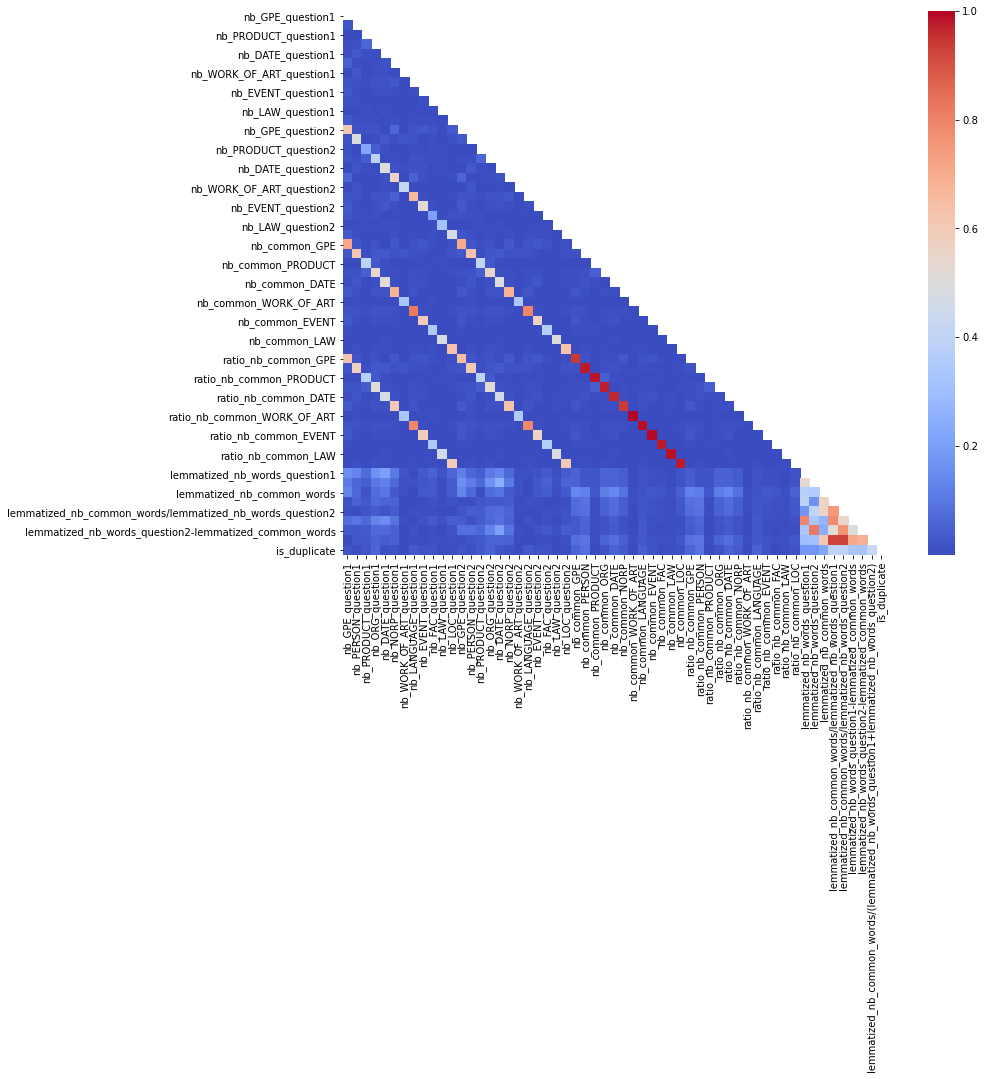

In [14]:
from sklearn import feature_selection

def independant_features_analysis(name_data,input_df,target_df):
    train_df = input_df[all_numeric_columns(input_df)]
    target_df = target_df
    small = int(len(target_df)*0.05)
    small_train = train_df.sample(small,random_state=42)
    small_target = target_df.sample(small,random_state=42)
    #small_weights = input_df[WEIGHT].sample(small,random_state=42)

    # be careful all_numeric will include also the target soon
    all_numeric = all_numeric_columns(input_df)
    print_section('Minimal analysis of numeric features of %s' % name_data)
    print_info('Nb features: %d' % len(all_numeric))
    print_info(str(all_numeric))
    print_warning('Is there any null value ? %s' % input_df.isnull().any().any())

    compute_variances = feature_selection.VarianceThreshold()
    all_numeric.append('is_duplicate')
    variances = compute_variances.fit_transform(input_df[all_numeric])
    print_warning('Is there any low variance feature ? %s' % str(variances.shape[1]!=len(all_numeric)))
    print_info('Here are the correlations to the target "is_duplicate"')
    correlation_matrix = input_df[all_numeric].corr().abs()
    print(correlation_matrix['is_duplicate'].nlargest(len(all_numeric)))

    correlation_matrix_without_is_duplicate = correlation_matrix['is_duplicate'][correlation_matrix['is_duplicate']<1]
    highest_correlated_feature = correlation_matrix_without_is_duplicate.nlargest(1).index[0]
    highest_correlation = correlation_matrix_without_is_duplicate.nlargest(1)[0]
    if highest_correlation >0.2:
        if highest_correlation < 0.5:
            print_warning('%s is the most correlated with target but %f is quite weak' % (highest_correlated_feature,highest_correlation))
        else:
            print_alert('%s is the most correlated with target and %f is quite big' % (highest_correlated_feature,highest_correlation))
    else:
            print_info('%s is the most correlated with target but %f is very weak' % (highest_correlated_feature,highest_correlation))
    plot.figure(figsize=(15, 10))
    sns.heatmap(correlation_matrix,annot=False,cbar=True,square=True,cmap='coolwarm',mask = numpy.triu(correlation_matrix))
    plot.show()

independant_features_analysis('train',train_dataframe,train_dataframe['is_duplicate'])

Now, for each type of entity, we have a dedicated column storing all entities
We add some counts
* For each type, the # of elements of the list in each question
* For each type, the # of common entities in questions. 
* For each type, The ratio Nb common entities/Nb entities

We will use it:
* for visualisation, by filtering on most common entities, we should generate usable wordclouds
* To help build a good model. Idea is to count the # of common entities for each type

Even if we won't do some exploration, we will need some code from exploration process

Rename columns so they can easily be merged with data from other notebooks

In [15]:
new_cols = dict()
train_dataframe = train_dataframe.rename(columns=dict([ (k,k.replace('nb_','nb_entities_')) for k in train_dataframe.columns if 'nb_' in k and 'lemma' not in k and 'entities' not in k]))
challenge_dataframe = challenge_dataframe.rename(columns=dict([ (k,k.replace('nb_','nb_entities_')) for k in challenge_dataframe.columns if 'nb_' in k and 'lemma' not in k and 'entities' not in k]))

Save it preciously in global repository

In [16]:
ALL_TRAIN_NUMERIC_COLUMNS = all_numeric_columns(train_dataframe)
assert 'qid1' not in ALL_TRAIN_NUMERIC_COLUMNS
assert 'question1' not in ALL_TRAIN_NUMERIC_COLUMNS
assert 'qid2' not in ALL_TRAIN_NUMERIC_COLUMNS
assert 'question2' not in ALL_TRAIN_NUMERIC_COLUMNS
assert WEIGHT  not in ALL_TRAIN_NUMERIC_COLUMNS

# Keep it preciously in global repo
save_global_dataframe(train_dataframe[ALL_TRAIN_NUMERIC_COLUMNS],'train_final_lemmatized_entities_features')

ALL_CHALLENGE_NUMERIC_COLUMNS = all_numeric_columns(challenge_dataframe)
assert ALL_CHALLENGE_NUMERIC_COLUMNS == ALL_TRAIN_NUMERIC_COLUMNS
save_global_dataframe(challenge_dataframe[ALL_CHALLENGE_NUMERIC_COLUMNS],'challenge_final_lemmatized_entities_features')


In [17]:
ALL_TRAIN_NUMERIC_COLUMNS

['nb_entities_GPE_question1',
 'nb_entities_PERSON_question1',
 'nb_entities_PRODUCT_question1',
 'nb_entities_ORG_question1',
 'nb_entities_DATE_question1',
 'nb_entities_NORP_question1',
 'nb_entities_WORK_OF_ART_question1',
 'nb_entities_LANGUAGE_question1',
 'nb_entities_EVENT_question1',
 'nb_entities_FAC_question1',
 'nb_entities_LAW_question1',
 'nb_entities_LOC_question1',
 'nb_entities_GPE_question2',
 'nb_entities_PERSON_question2',
 'nb_entities_PRODUCT_question2',
 'nb_entities_ORG_question2',
 'nb_entities_DATE_question2',
 'nb_entities_NORP_question2',
 'nb_entities_WORK_OF_ART_question2',
 'nb_entities_LANGUAGE_question2',
 'nb_entities_EVENT_question2',
 'nb_entities_FAC_question2',
 'nb_entities_LAW_question2',
 'nb_entities_LOC_question2',
 'nb_entities_common_GPE',
 'nb_entities_common_PERSON',
 'nb_entities_common_PRODUCT',
 'nb_entities_common_ORG',
 'nb_entities_common_DATE',
 'nb_entities_common_NORP',
 'nb_entities_common_WORK_OF_ART',
 'nb_entities_common_LANGU

# Similarity
A whole new kind of information provided by spacy : similarity

Globally, exactly we are searching : each word, each sentence, each doc is associated to a vector
And it is possible to compare vectors with simple operation provided by spacy (most probably a cosine distance)

We load a huge model with plenty of vectors (one million words)

In [18]:

spacy_nlp = spacy.load('en_core_web_md',disable=['tagger','parser','textcat'])

In [19]:


def spacy_similarity(dataframe):
    start = time.time()
    similarities = list()
    print_info('Compute spacy similarities')
    for d1,d2 in tqdm(
        zip(
            spacy_nlp.pipe(dataframe['question1'],batch_size=1000,n_process=os.cpu_count()-1), 
            spacy_nlp.pipe(dataframe['question2'],batch_size=1000,n_process=os.cpu_count()-1)),
        total=len(dataframe)):
        similarities.append(d1.similarity(d2))
    dataframe['spacy_similarity'] = similarities
    print_done('Done',top=start)
    return dataframe


train_dataframe = load_or_build_dataframe('Training data: compute spacy similarities','training_simmilarities',spacy_similarity,train_dataframe)
challenge_dataframe = load_or_build_dataframe('Challenge data: compute spacy similarities','challenge_similarities',spacy_similarity,challenge_dataframe)


We have massively saved all columns we have...

Let's save only the spacy_similarity in global repository, so other notebooks can use it

In [25]:
save_global_dataframe(train_dataframe['spacy_similarity'],'train_spacy_similarity')
save_global_dataframe(challenge_dataframe['spacy_similarity'],'challenge_spacy_similarity')

Is this useful

Manual check on values of similarity
* max 1. Several things like
    * how can i get a phone 6 with water damage repair in hyderabad
    * how can i get a phone 6 with water damage repair in delhi
get a 1 similarity and are not duplicates
* negative values like
    * what be the psychological explanation to the existence of rudalis in time of raja in india & 
    * ماذا علي ان افعل لكي اشعر بالسعادة و الرضى ؟

Spacy's similarity is near but not fully equivalent to is_duplicate

In [26]:
train_dataframe[['spacy_similarity','is_duplicate','question1','question2']].sort_values('spacy_similarity',ascending=False)

,spacy_similarity,is_duplicate,question1,question2
321252,1.000000,0,what be some lesser know sight to see when visit icheon south korea,what be some lesser know sight to see when visit wonju south korea
46202,1.000000,0,how can i spend my monthly salary of 15000 wisely if stay in bangalore at the age of 22,how can i spend my monthly salary of 20000 wisely if stay in bangalore at the age of 22
221031,1.000000,0,to what extent be twitter a threat to quora,to what extent be quora a threat to twitter
338824,1.000000,0,what happen when you mix calcium hydroxide and sulphuric acid,what happen when you mix calcium hydroxide and hydrochloric acid
372252,1.000000,1,what be the technical skill require by a b tech graduate from eee branch to get a good placement,what be the technical skill require by a b tech graduate from eee branch to get a good placement
...,...,...,...,...
303016,-0.104558,0,aima busness analytics,aside from finance investment bank wall street what be some other common high pay career in nyc
161161,-0.164953,0,biji kurdistan,why be many turks very against to gulenists and consider gulen movement a a danger to the state
188019,-0.173504,1,shaurya bharadwaj shifuji,who be shifuji
144343,-0.305740,0,what be the psychological explanation to the existence of rudalis in time of raja in india,ماذا علي ان افعل لكي اشعر بالسعادة و الرضى ؟


Let's dig a little more
Basically, we are exploring manually the confusion matrix
How many
* similarities =1 and is_duplicate = 1
* similarities =1 and is_duplicate = 0


In [27]:
print_info('similary=1 & is_duplicate=1 %.3f' % (100.*train_dataframe[(train_dataframe['spacy_similarity']==1.0) & (train_dataframe['is_duplicate']==1)]['is_duplicate'].count()/len(train_dataframe)))
print_info('similary=1 & is_duplicate=0 %.3f' % (100.*train_dataframe[(train_dataframe['spacy_similarity']==1.0) & (train_dataframe['is_duplicate']==0)]['is_duplicate'].count()/len(train_dataframe)))


Not so bad

similarities <0.5 and is_duplicate = 1
similarities <0.5 and is_duplicate = 0


In [28]:
print_info('similary>0.5 & is_duplicate=1 %.3f' % (100.*train_dataframe[(train_dataframe['spacy_similarity']>0.5) & (train_dataframe['is_duplicate']==1)]['is_duplicate'].count()/len(train_dataframe)))
print_info('similary<0.5 & is_duplicate=0 %.3f' % (100.*train_dataframe[(train_dataframe['spacy_similarity']<0.5) & (train_dataframe['is_duplicate']==0)]['is_duplicate'].count()/len(train_dataframe)))

## Do not forget Challenge and training are not equivalent

% of duplicate in training is not the same in challenge !
We don't have the challenge's answer but by scoring a constant prediction and using logloss definition, we can guess the distribution of duplicates in challenge

It's 17.46 %

To fix that we can:

* duplicate some negative cases in training to match challenge distribution
* use weights : each case has a weight !=1 and all algorithms are supposed to be able to deal with that info
I choose to use weights (less memory needed ?)

In [30]:
# return the weight for 0 and weight for 1 needed to rebalance dataframe like challenge
def balanced_weights(dataframe,expected_positive_ratio):
    current_positive_ratio = dataframe['is_duplicate'].sum()/len(dataframe)
    weight_for_negative = (1-expected_positive_ratio)/(1-current_positive_ratio)
    weight_for_positive = expected_positive_ratio/current_positive_ratio
    return weight_for_positive,weight_for_negative
    return 1,


CHALLENGE_DUPLICATE_PERCENT = 0.1746
print_warning('OUPS !! %% of duplicates in train is %.3f. In challenge it is %.3f %%' % (train_dataframe['is_duplicate'].sum()/len(train_dataframe),CHALLENGE_DUPLICATE_PERCENT))

# create a new 'weight' column to training dataset
# Do not forget to remove this column from features !!!
weight_for_1,weight_for_0 = balanced_weights(train_dataframe,CHALLENGE_DUPLICATE_PERCENT)
print_info('Weight for positive case %.3f' % weight_for_1)
print_info('Weight for negative case %.3f' % weight_for_0)
train_dataframe['weight'] = train_dataframe['is_duplicate'].map( {0:weight_for_0, 1:weight_for_1})

assert int(train_dataframe['weight'].sum()/len(train_dataframe)) == 1, "training dataset has not been properly rebalanced"
print_info("Training data set has been properly rebalanced")
print_info('Weights distribution:')
train_dataframe['weight'].describe()

count    404290.000000
mean          1.000000
std           0.403239
min           0.472917
25%           0.472917
50%           1.308493
75%           1.308493
max           1.308493
Name: weight, dtype: float64

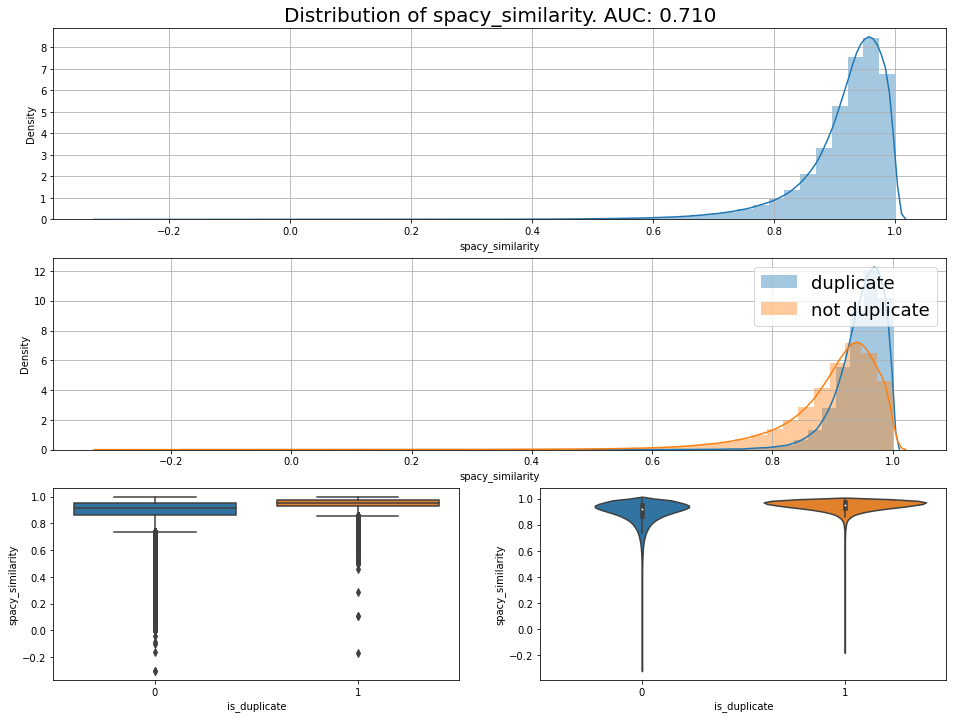

In [32]:
from sklearn.metrics import roc_auc_score


def simple_AUC(dataframe,column_name):
    return roc_auc_score(y_true=dataframe['is_duplicate'],y_score=dataframe[column_name])

def simple_weighted_AUC(dataframe,column_name):
    return roc_auc_score(y_true=dataframe['is_duplicate'],y_score=dataframe[column_name],sample_weight=dataframe['weight'])

def show_AUC(dataframe,column_name):
    if 'weight' in dataframe.columns:
        print_bullet('AUC (with weight) %s %f' % (column_name,simple_weighted_AUC(dataframe,column_name)))
    else:
        print_bullet('AUC %s: %f' % (column_name,simple_AUC(dataframe,column_name)))
        

def display_simple_AUC_exp(dataframe,column_name,nb_bins=50):
    palette = sns.color_palette()
    plot.figure(figsize=(10, 10))
    plot.hist(dataframe[column_name][dataframe['is_duplicate']==1],bins=nb_bins,color=palette[3],label='Same',histtype='step')
    plot.hist(train_dataframe[column_name][dataframe['is_duplicate']==0],bins=nb_bins,color=palette[2],label='Different',alpha = 0.75,histtype='step')
    plot.title('Distribution %s : %f' % (column_name,simple_AUC(dataframe,column_name)) , fontsize=10)
    plot.xlabel(column_name)
    plot.grid(True)
    plot.ylabel('Nb')
    plot.legend()


## display tons of infos about column_name and its relation with target
def display_simple_AUC(dataframe, column_name,nb_bins=50):
    fig = plot.figure(figsize=(16, 12))
    ax1 = plot.subplot2grid((3, 2), (0, 0), colspan=2)
    ax2 = plot.subplot2grid((3, 2), (1, 0), colspan=2)
    ax3 = plot.subplot2grid((3, 2), (2, 0))
    ax4 = plot.subplot2grid((3, 2), (2, 1))
    ax1.set_title('Distribution of %s. AUC: %.3f' % (column_name,simple_weighted_AUC(dataframe,column_name)), fontsize=20)
    sns.distplot(dataframe[column_name], bins=nb_bins, ax=ax1)  
    ax1.grid(True)
    sns.distplot(dataframe[dataframe['is_duplicate']==1][column_name], ax=ax2, label='duplicate', kde=True)    
    sns.distplot(dataframe[dataframe['is_duplicate']==0][column_name], bins=nb_bins,  ax=ax2, label='not duplicate', kde=True)
    ax2.grid(True)
    ax2.legend(loc='upper right', prop={'size': 18})
    sns.boxplot(y=column_name, x='is_duplicate', data=dataframe, ax=ax3)
    # we have some VERYYYY long variable names
    if len(column_name)>30:
        ax3.set_ylabel(column_name,fontsize=7)
    sns.violinplot(y=column_name,  x='is_duplicate',  data=dataframe,  ax=ax4)
    if len(column_name)>30:
        ax4.set_ylabel(column_name,fontsize=6.5)
    plot_save('distrib_'+column_name.replace('/','_div_').replace(' ','_'))
    plot.show()


show_AUC(train_dataframe,'spacy_similarity')
display_simple_AUC(train_dataframe,'spacy_similarity')